In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, to_timestamp, count, radians, sin, cos, sqrt, asin, lag, sum as _sum, round as spark_round
)
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
import os

# import findspark

# os.environ["SPARK_LOCAL_IP"] = "IP"
# os.environ["PYSPARK_PYTHON"] = r"C:\.....\pyspark_env\python.exe"
# os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\....\pyspark_env\python.exe"

# findspark.init()

# spark = (
#     SparkSession.builder
#     .appName("PortDetectionTask1")
#     .master("local[*]")
#     .getOrCreate()
# )

spark = SparkSession.builder.master("local[8]").appName("PortDetectionTask").getOrCreate()

df = spark.read.csv("aisdk-2025-04-20.csv",
    header=True,
    inferSchema=True
)


def clean_data(df):
    '''
    Takes a dataframe, returns a cleaned one.

    Only take useful columns, drop NA values, cast to appopriate data types.
    Remove ships with non-standart coordinate types, helicopters.
    '''
    # Some standard cleaning
    df_clean = (
        df.select("MMSI", "# Timestamp", "Latitude", "Longitude", "SOG", "Ship type")
        .dropna(subset=["MMSI", "# Timestamp", "Latitude", "Longitude", "SOG"])
        .withColumn("Latitude", col("Latitude").cast(DoubleType()))
        .withColumn("Longitude", col("Longitude").cast(DoubleType()))
        .withColumn("SOG", col("SOG").cast(DoubleType()))
        .withColumn("Timestamp", to_timestamp(col("# Timestamp"), "dd/MM/yyyy HH:mm:ss"))
    )

    # Cleaning up the ships with weird coordinates
    df_clean = df_clean.filter(
        (col("Latitude").between(-90, 90)) &
        (col("Longitude").between(-180, 180))
    )

    # Remove search and rescue helicopters from the analysis
    df_clean = df_clean.filter(
        col("Ship type") != "SAR"
    )

    return df_clean


def filter_moving_ships(df_clean, sog_filter=0.5, sog_number_filter=5, total_distance_filter=10.0):
    '''
    Takes a dataframe and filtering parameters, returns a filtered one of stationary vessels.

    Remove vessels based on these two conditions:
        1. Moving vessels that send speed of 0.5 or higher for more than 5 times.
        2. Ones that have traveled for more than 10 kilometers in the given day.
    '''
    # Ships that are sending SOG >= (0.5) for more than (5) time are excluded.
    low_speed_df = df_clean.filter(col("SOG") < sog_filter)

    dwelling_ships = (
        low_speed_df.groupBy("MMSI")
                    .agg(count("*").alias("low_speed_msgs"))
                    .filter(col("low_speed_msgs") >= sog_number_filter)
    )

    slow_moving_df = (
        low_speed_df.join(dwelling_ships, on="MMSI", how="inner")
    )

    # Display the slow ships
    total_slow_moving_ships = slow_moving_df.select("MMSI").distinct().count()
    print(f"Total stationary/drifting ships: {total_slow_moving_ships}")

    slow_moving_df.show(5, truncate=False)

    # Now distance filtering is performed
    low_speed_filtered = slow_moving_df

    # Window.partition function for previous coordinates
    windowSpec = Window.partitionBy("MMSI").orderBy("Timestamp")

    df_distance = (
        low_speed_filtered.withColumn("prev_lat", lag("Latitude").over(windowSpec))
                        .withColumn("prev_lon", lag("Longitude").over(windowSpec))
                        .dropna(subset=["prev_lat", "prev_lon"])
    )

    # Convert to radians for distance calculation
    df_distance = (
        df_distance.withColumn("lat1", radians(col("prev_lat")))
                .withColumn("lon1", radians(col("prev_lon")))
                .withColumn("lat2", radians(col("Latitude")))
                .withColumn("lon2", radians(col("Longitude")))
    )


    # Calculate haversine distance in pyspark SQL
    df_distance = (
        df_distance.withColumn("dlat", col("lat2") - col("lat1"))
                .withColumn("dlon", col("lon2") - col("lon1"))
                .withColumn("a", sin(col("dlat") / 2) ** 2 +
                                    cos(col("lat1")) * cos(col("lat2")) *
                                    sin(col("dlon") / 2) ** 2)
                .withColumn("c", 2 * asin(sqrt(col("a"))))
                .withColumn("segment_km", col("c") * 6371) 
    )

    # Total distance traveled by MMSI
    total_distance = (
        df_distance.groupBy("MMSI")
                .agg(_sum("segment_km").alias("total_distance_km"))
    )

    # Filter ships that traveled more than (10)km
    stationary_ships = total_distance.filter(col("total_distance_km") < total_distance_filter)

    # Join the filtered low speed ships and the filtered small distance traveled ships
    df_filtered = low_speed_filtered.join(stationary_ships, on="MMSI", how="inner")

    return df_filtered


In [2]:
# Filtering results
df_clean = clean_data(df)
df_filtered = filter_moving_ships(df_clean)

total_stationary_ships = df_filtered.select("MMSI").distinct().count()
print(f"Total stationary/drifting ships: {total_stationary_ships}")

df_filtered.show(5, truncate=False)

Total stationary/drifting ships: 3078
+---------+-------------------+---------+---------+---+---------+-------------------+--------------+
|MMSI     |# Timestamp        |Latitude |Longitude|SOG|Ship type|Timestamp          |low_speed_msgs|
+---------+-------------------+---------+---------+---+---------+-------------------+--------------+
|219024194|20/04/2025 00:00:01|54.995438|11.874798|0.0|Undefined|2025-04-20 00:00:01|11417         |
|246389000|20/04/2025 00:00:02|54.994648|11.87351 |0.0|Undefined|2025-04-20 00:00:02|15552         |
|246389000|20/04/2025 00:00:02|54.994648|11.87351 |0.0|Undefined|2025-04-20 00:00:02|15552         |
|257476500|20/04/2025 00:00:03|56.701   |8.21937  |0.0|Undefined|2025-04-20 00:00:03|16294         |
|257476500|20/04/2025 00:00:03|56.701   |8.21937  |0.0|Undefined|2025-04-20 00:00:03|16294         |
+---------+-------------------+---------+---------+---+---------+-------------------+--------------+
only showing top 5 rows

Total stationary/drifting sh

In [6]:
df_filtered.groupBy("Ship type").count().orderBy("count", ascending=False).show()

+---------------+-------+
|      Ship type|  count|
+---------------+-------+
|        Fishing|2463211|
|          Other| 374638|
|          Cargo| 348770|
|       Pleasure| 346419|
|            Tug| 274958|
|          Pilot| 252789|
|        Sailing| 251809|
|      Passenger| 245374|
|       Dredging| 190984|
|      Undefined| 165755|
|         Tanker| 132113|
|       Military|  80599|
|       Reserved|  70828|
|            HSC|  56624|
|    Port tender|  33997|
|         Towing|  25141|
|Law enforcement|  17229|
|        Medical|   8499|
|         Diving|   7582|
| Anti-pollution|   2370|
+---------------+-------+
only showing top 20 rows



In [3]:
from pyspark.sql.functions import (
    col, to_timestamp, count, radians, sin, cos, sqrt, asin, lag, sum as _sum, round as spark_round, count_distinct, count
)

def bin_ships(df, filter_ships=5):
    '''
    Bin ships to clusters based on lattidute and longitude.
    Grid size is approximately 0.64 x 1.11km rectangles (roughly 0.7km squared), may differ depending on latidute and longitude.
    '''

    binned_df = (
        df.withColumn("lat_bin", spark_round(col("Latitude"), 2))
        .withColumn("lon_bin", spark_round(col("Longitude"), 2))
    )
    
    port_candidates = (
        binned_df.groupBy("lat_bin", "lon_bin")
                .agg(count_distinct("MMSI").alias("vessel_count"))
                .filter(col("vessel_count") >= filter_ships)
    )
    
    port_candidates.orderBy(col("vessel_count").desc()).show(truncate=False)
    
    return port_candidates

port_candidates = bin_ships(df_filtered)
port_candidates.show(5, truncate=False)

+-------+-------+------------+
|lat_bin|lon_bin|vessel_count|
+-------+-------+------------+
|57.59  |9.96   |56          |
|57.12  |8.6    |44          |
|56.7   |8.22   |43          |
|54.38  |10.98  |40          |
|57.72  |10.59  |34          |
|56.13  |12.31  |28          |
|55.06  |10.62  |22          |
|56.41  |10.92  |21          |
|54.81  |9.45   |21          |
|57.06  |9.9    |19          |
|55.1   |14.69  |18          |
|57.49  |10.5   |18          |
|54.85  |10.52  |17          |
|54.67  |9.94   |16          |
|55.33  |11.13  |16          |
|55.47  |8.42   |16          |
|55.69  |12.62  |16          |
|57.49  |10.51  |15          |
|55.19  |14.7   |15          |
|55.59  |12.68  |14          |
+-------+-------+------------+
only showing top 20 rows

+-------+-------+------------+
|lat_bin|lon_bin|vessel_count|
+-------+-------+------------+
|54.47  |9.04   |9           |
|54.91  |9.6    |6           |
|57.59  |9.95   |8           |
|54.91  |9.89   |8           |
|54.18  |12.1

In [11]:
def bin_ports(df):
    '''
    Bin ports to clusters based on lattidute and longitude.
    Grid cell size is approximately 6.4 × 11.1km rectangles (roughly 71km squared), may differ depending on latidute and longitude.
    '''

    binned_df = (
        df.withColumn("lat_bin_ports", spark_round(col("lat_bin"), 1))
        .withColumn("lon_bin_ports", spark_round(col("lon_bin"), 1))
    )
    
    port_candidates_agg = (
        binned_df.groupBy("lat_bin_ports", "lon_bin_ports")
                .agg(_sum("vessel_count").alias("vessel_total_count"))
    )
    
    port_candidates_agg.orderBy(col("vessel_total_count").desc()).show(truncate=False)
    
    return port_candidates_agg

port_candidates_agg = bin_ports(port_candidates)
port_candidates_agg.show(5)

+-------------+-------------+------------------+
|lat_bin_ports|lon_bin_ports|vessel_total_count|
+-------------+-------------+------------------+
|57.6         |10.0         |76                |
|55.7         |12.6         |73                |
|57.7         |10.6         |63                |
|57.1         |8.6          |55                |
|54.4         |11.0         |54                |
|57.5         |10.5         |44                |
|55.5         |8.4          |44                |
|56.7         |8.2          |43                |
|55.6         |12.4         |31                |
|57.1         |9.9          |31                |
|56.1         |12.3         |28                |
|55.1         |14.7         |28                |
|54.6         |11.4         |26                |
|55.6         |12.9         |23                |
|55.6         |12.7         |23                |
|55.1         |10.6         |22                |
|56.4         |10.9         |21                |
|54.8         |9.5  

 # Finding ports with K-mean

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql.functions import countDistinct, col
import folium
import builtins

In [35]:
# making as vector filtered data for knn analysis, where the features column is  made from the latitude and longitude

def make_vector(data):
    vec_assembler = VectorAssembler(inputCols=["Longitude", "Latitude"], outputCol="features")
    features_df = vec_assembler.transform(data)
    return features_df
features_df=make_vector(df_filtered)

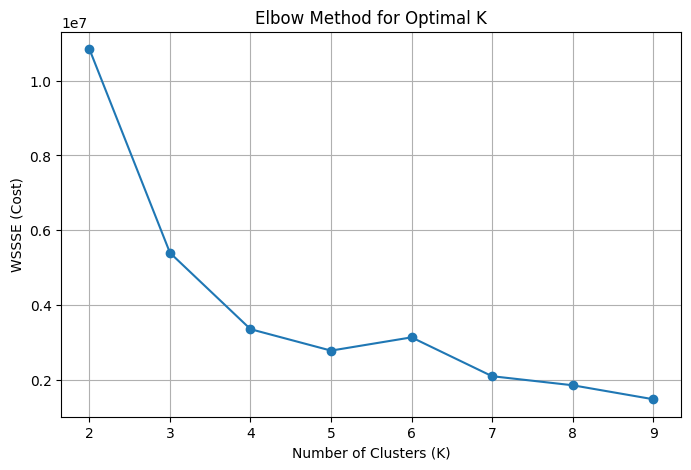

In [36]:
# Making elbow graph, to check the most suitable port number for the data
def elbow(data):
# Elbow method: WSSSE unique K
    costs = []
    K_values = list(range(2, 10))
    for k in K_values:
        kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
        model = kmeans.fit(data)
        wssse = model.summary.trainingCost
        costs.append(wssse)
    
    plt.figure(figsize=(8, 5))
    plt.plot(K_values, costs, marker='o')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("WSSSE (Cost)")
    plt.title("Elbow Method for Optimal K")
    plt.grid(True)
    plt.show()

elbow(features_df)


In [38]:
# performing knn clustering with k={7,15,20} 
def perform_knn(k, feature_df):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(features_df)
    centers = model.clusterCenters()
    
    # Adding to each row cluster number 
    clustered = model.transform(features_df)
    return centers, clustered


centers7, clustered7 = perform_knn(7, features_df)
centers15, clustered15 = perform_knn(15, features_df)
centers20, clustered20 = perform_knn(20, features_df)

In [39]:
#printing cluster center coordinates
def print_cluster_centers(centers, k):
    print(f"Clusters (k={k}) centers")
    for idx, center in enumerate(centers):
        print(f"Cluster {idx}: Longitude = {center[0]}, Latitude = {center[1]}")


print_cluster_centers(centers7, 7)
print_cluster_centers(centers15, 15)
print_cluster_centers(centers20, 20)

Clusters (k=7) centers
Cluster 0: Longitude = 8.343303239646715, Latitude = 56.30171838814669
Cluster 1: Longitude = 10.725273505026559, Latitude = 57.4797282731395
Cluster 2: Longitude = 12.402596118334511, Latitude = 55.996068633844686
Cluster 3: Longitude = 11.205349432793415, Latitude = 54.92603416019652
Cluster 4: Longitude = 9.974455024926149, Latitude = 55.33144816366822
Cluster 5: Longitude = 9.976716826087571, Latitude = 57.512050640147294
Cluster 6: Longitude = 14.593015445250684, Latitude = 55.105046184824644
Clusters (k=15) centers
Cluster 0: Longitude = 12.84792940835756, Latitude = 55.28153338534484
Cluster 1: Longitude = 8.511925794063982, Latitude = 56.8634644679219
Cluster 2: Longitude = 12.54186584411251, Latitude = 55.89977729919238
Cluster 3: Longitude = 10.634864691447655, Latitude = 57.56065988437027
Cluster 4: Longitude = 8.489666917959738, Latitude = 55.29615523610188
Cluster 5: Longitude = 11.70716016938952, Latitude = 55.91206632877253
Cluster 6: Longitude = 1

In [40]:
# counting vessel number for each cluster for each experiment (k={7,15,20})
def count_vessel_in_cluster(clustered):
    cluster_counts = clustered.groupBy("prediction").agg(countDistinct("MMSI").alias("ship_count"))
    cluster_counts.show()

count_vessel_in_cluster(clustered7)
count_vessel_in_cluster(clustered15)
count_vessel_in_cluster(clustered20)

+----------+----------+
|prediction|ship_count|
+----------+----------+
|         1|       324|
|         6|       143|
|         3|       382|
|         5|       168|
|         4|       573|
|         2|       519|
|         0|       296|
+----------+----------+

+----------+----------+
|prediction|ship_count|
+----------+----------+
|        12|       140|
|         1|       164|
|        13|        16|
|         6|       136|
|         3|       204|
|         5|        87|
|         9|       135|
|         4|       132|
|         8|       410|
|         7|        39|
|        10|       168|
|        11|       229|
|        14|       116|
|         2|       325|
|         0|       100|
+----------+----------+

+----------+----------+
|prediction|ship_count|
+----------+----------+
|        12|        40|
|         1|       105|
|        13|        16|
|        16|        90|
|         6|        61|
|         3|        41|
|         5|       106|
|        19|       252|
|        15|  

## Visualizations of knn results

In [41]:
def visualize_clusters_knn(clustered, k):
    # 1. Group data by cluster prediction and aggregate:
    #    - count distinct vessels (MMSI) per cluster as 'vessel_count'
    #    - average latitude and longitude per cluster for map positioning
    summary_df = clustered.groupBy("prediction").agg(
        countDistinct("MMSI").alias("vessel_count"),
        avg("latitude").alias("lat_bin"),
        avg("longitude").alias("lon_bin")
    ).withColumnRenamed("prediction", "cluster_id") \
     .filter(col("vessel_count") >= 20)  # Filter clusters with at least 20 vessels  to automatically distinguish 
    #ports or major gathering points from small, possibly transient groups of vessels like fishing boats.
    
    # 2. Convert Spark DataFrame to Pandas DataFrame for easier iteration
    port_candidates_pd = summary_df.toPandas()
    
    # 3. Calculate mean latitude and longitude to center the Folium map
    mean_lat = port_candidates_pd["lat_bin"].mean()
    mean_lon = port_candidates_pd["lon_bin"].mean()
    
    # 4. Create a Folium map centered at the average coordinates
    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=6)
    
    # 5. Add circle markers ("bubbles") to the map for each cluster
    for _, row in port_candidates_pd.iterrows():
        vessel_count = int(row["vessel_count"])  # Explicitly convert vessel_count to int
        radius = builtins.min(vessel_count, 20)  # Limit radius size to max 20 for visualization
        
        folium.CircleMarker(
            location=[row["lat_bin"], row["lon_bin"]],
            radius=radius,
            color="blue",
            fill=True,
            fill_opacity=0.6,
            popup=f"Vessels: {vessel_count}, Cluster: {row['cluster_id']}"
        ).add_to(m)
    
    # 6. Save the generated map as an HTML file with dynamic filename including k
    m.save(f"port_clusters_map_knn_{k}.html")


In [42]:
visualize_clusters_knn(clustered7, 7)

In [43]:
visualize_clusters_knn(clustered15,15)

In [44]:
visualize_clusters_knn(clustered20, 20)